# Developing functions to make better size and frame plots

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filepath = "processed-data/thp1_v2/process/ansari.transcript.mapped.wts.sam"
# samfile = pysam.AlignmentFile(filepath, "rb")

In [2]:
gene_len_filepath = "iXnos/genome_data/gencode.v22.transcript.13cds10.lengths.txt"

gene_len_df = pd.read_csv(
    gene_len_filepath,
    sep="\t", header=None, index_col=0)

In [3]:
global_utr5_len = None
utr5_lens = gene_len_df.iloc[:, 0].unique()
if len(utr5_lens) == 1:
    global_utr5_len = utr5_lens.item()

In [11]:
size_and_frame_dict = {}
utr5_len_dict = gene_len_df.iloc[:, 0].to_dict()
gene_len_dict = gene_len_df.iloc[:, 1].to_dict()
reads = set() # Store reads

with open(filepath, "r") as samfile:
    for line in samfile:
        if line[0] == "@":
            continue
        line = line.strip().split()
        read_id = line[0]
        # Don't count read if you've seen it before
        if read_id in reads:
            continue
        reads.add(read_id)
        gene = line[2]
        cds_len = gene_len_dict[gene]
        if global_utr5_len is not None:
            utr5_len = global_utr5_len
        else:
            utr5_len = utr5_len_dict[gene]
        map_pos = int(line[3]) - 1 - utr5_len
        if map_pos < -15 or map_pos > cds_len - 9:
            continue
        seq = line[9]
        size = len(seq)
        frame = map_pos % 3
        if size not in size_and_frame_dict.keys():
            size_and_frame_dict[size] = {i : 0 for i in range(3)}
        size_and_frame_dict[size][frame] += 1

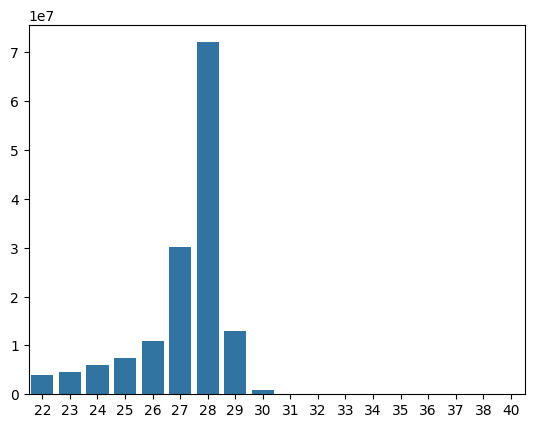

In [12]:
size_and_frame = (
    pd.DataFrame(size_and_frame_dict)
    .T
    .sort_index()
    )
sns.barplot(size_and_frame.sum(axis=1))
plt.show()

In [13]:
size_and_frame.sum(axis=1)

22     3934258
23     4511120
24     5909764
25     7513841
26    10915707
27    30190515
28    72025049
29    13044438
30      884591
31       81809
32       18975
33        4969
34        1349
35         319
36          87
37           9
38           5
40           1
dtype: int64

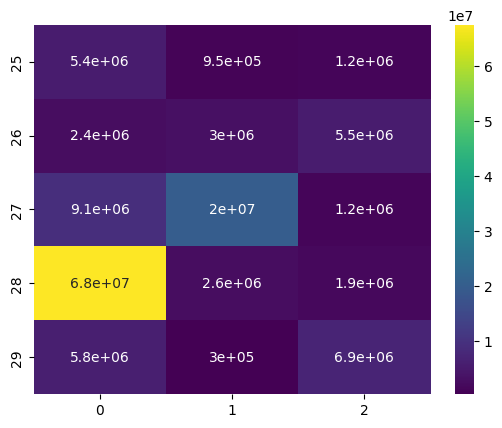

In [14]:
min_fp_size = 25
max_fp_size = 29

min_size=13
max_size=36

size_and_frame = size_and_frame.loc[range(min_fp_size, max_fp_size + 1)]

sns.heatmap(size_and_frame, annot=True, cmap="viridis")
plt.show()